# **TUTORIAL: Understanding Support Vector Machines (SVM) with Different Kernels**

Link to Github repo: [GitHub Repo](https://github.com/tanveer135/svm-kernels-tutorial.git)

## Learning Objectives:
- Understand what Support Vector Machines are and how they work
- Learn about the kernel trick and why it's powerful
- Explore three main kernel types: Linear, Polynomial, and RBF
- Visualize how different kernels create different decision boundaries
- Compare performance of different kernels on real data
- Learn when to use each kernel type

## Dataset: Iris Dataset
- 150 samples of iris flowers
- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: Setosa, Versicolor, Virginica



# IMPORT LIBRARIES AND SETUP
We'll need these libraries for our tutorial


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# LOAD AND EXPLORE THE IRIS DATASET

The Iris dataset is perfect for demonstrating SVM kernels because:
1. It's well-known and easy to understand
2. It has clear class separation (especially for 2 classes)
3. It's small enough to visualize easily
4. It demonstrates when linear vs non-linear kernels are needed

In [3]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data  # Features: sepal length, sepal width, petal length, petal width
y = iris.target  # Target: 0=Setosa, 1=Versicolor, 2=Virginica

In [4]:
# Create a DataFrame for easier viewing
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, iris.target_names)

In [5]:
print("\n" + "="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nDataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class names: {iris.target_names}")
print(f"\nClass distribution:")
print(pd.Series(y).value_counts().sort_index())

print("\nFirst few rows of the dataset:")
print(iris_df.head(10))

print("\nStatistical summary:")
print(iris_df.describe())


DATASET OVERVIEW

Dataset shape: (150, 4)
Number of samples: 150
Number of features: 4
Number of classes: 3
Class names: ['setosa' 'versicolor' 'virginica']

Class distribution:
0    50
1    50
2    50
Name: count, dtype: int64

First few rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4        

# VISUALIZE THE DATA

Visualization is crucial for understanding why different kernels work better
for different types of data. Let's look at our data in 2D using the two
most informative features.


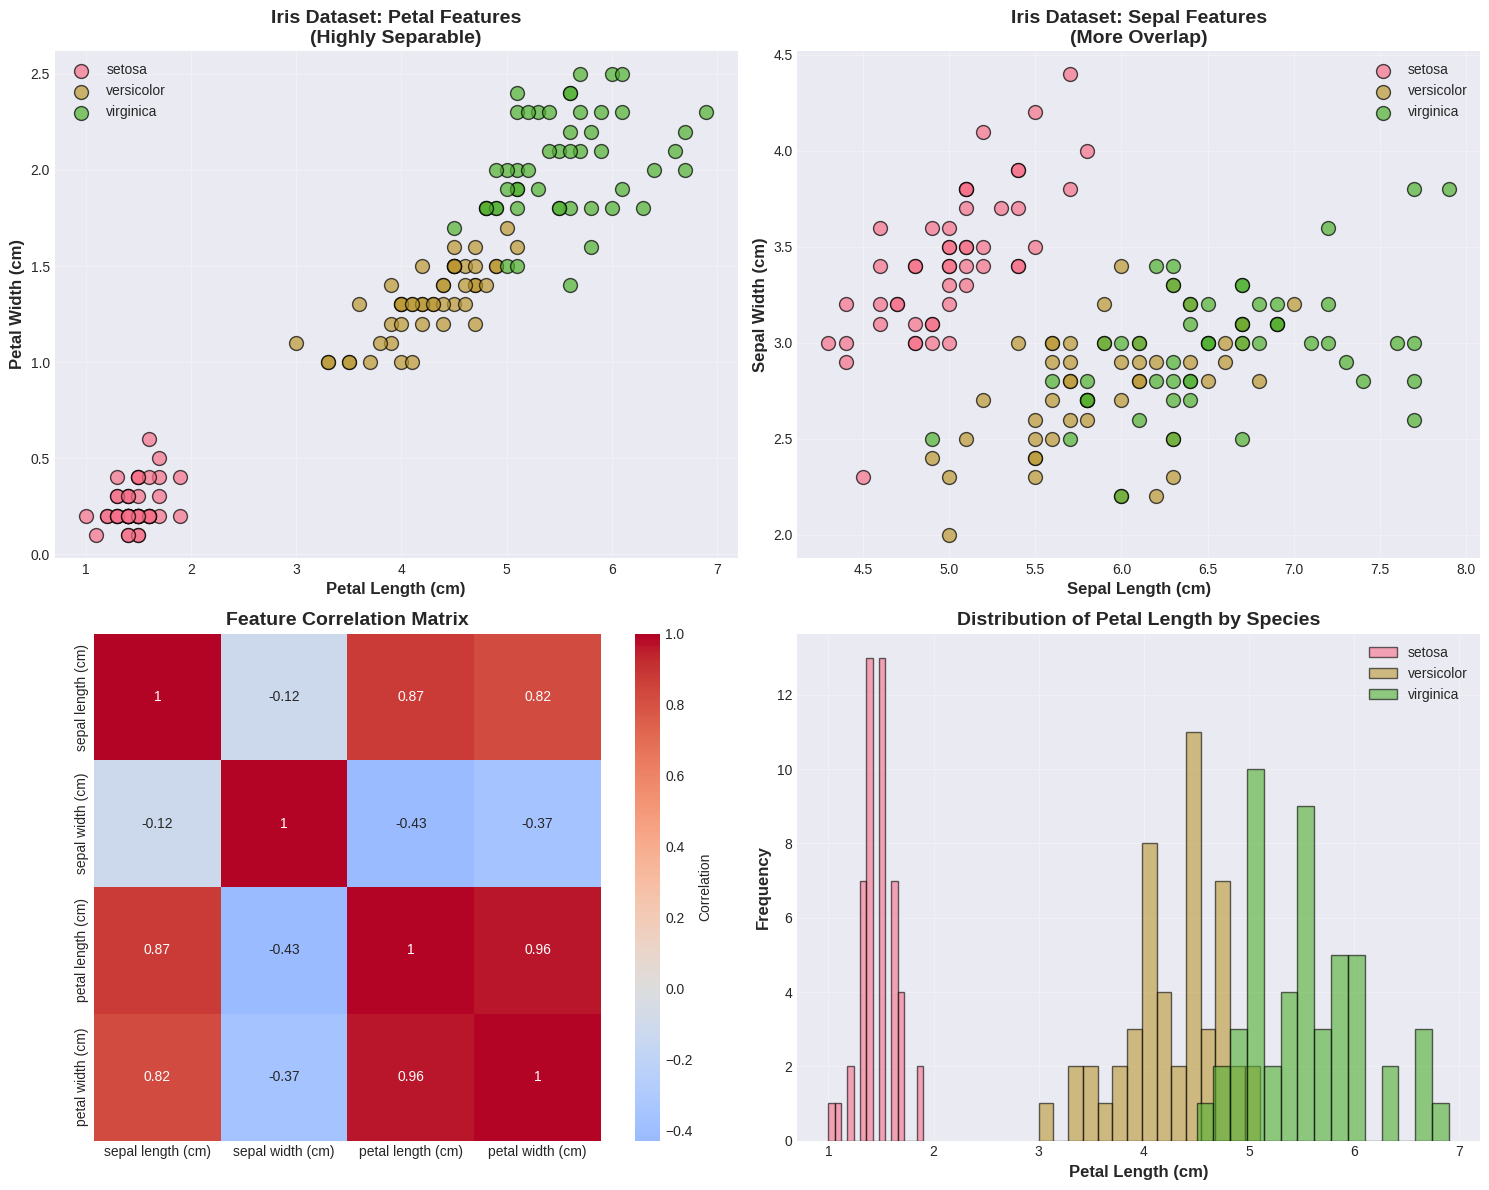


KEY OBSERVATIONS FROM DATA EXPLORATION:
1. Setosa is clearly separated from the other two species
2. Versicolor and Virginica have some overlap
3. Petal measurements are more discriminative than sepal measurements
4. This suggests we might need non-linear kernels for perfect separation


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Petal Length vs Petal Width (most separable)
ax1 = axes[0, 0]
for i, species in enumerate(iris.target_names):
    mask = y == i
    ax1.scatter(X[mask, 2], X[mask, 3], label=species, alpha=0.7, s=100, edgecolors='k')
ax1.set_xlabel('Petal Length (cm)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Petal Width (cm)', fontsize=12, fontweight='bold')
ax1.set_title('Iris Dataset: Petal Features\n(Highly Separable)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sepal Length vs Sepal Width (less separable)
ax2 = axes[0, 1]
for i, species in enumerate(iris.target_names):
    mask = y == i
    ax2.scatter(X[mask, 0], X[mask, 1], label=species, alpha=0.7, s=100, edgecolors='k')
ax2.set_xlabel('Sepal Length (cm)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sepal Width (cm)', fontsize=12, fontweight='bold')
ax2.set_title('Iris Dataset: Sepal Features\n(More Overlap)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Feature correlation heatmap
ax3 = axes[1, 0]
correlation_matrix = iris_df.iloc[:, :-1].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=ax3, cbar_kws={'label': 'Correlation'})
ax3.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 4: Feature distributions by class
ax4 = axes[1, 1]
feature_idx = 2  # Petal length
for i, species in enumerate(iris.target_names):
    mask = y == i
    ax4.hist(X[mask, feature_idx], alpha=0.6, label=species, bins=15, edgecolor='black')
ax4.set_xlabel('Petal Length (cm)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Distribution of Petal Length by Species', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('iris_data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS FROM DATA EXPLORATION:")
print("="*70)
print("1. Setosa is clearly separated from the other two species")
print("2. Versicolor and Virginica have some overlap")
print("3. Petal measurements are more discriminative than sepal measurements")
print("4. This suggests we might need non-linear kernels for perfect separation")

# PREPARE DATA FOR MODELING

For this tutorial, we'll use only 2 features to make visualization easier.
We'll choose petal length and petal width as they show the best separation.
In practice, you'd use all features for better performance.

In [8]:
# Select only two features for 2D visualization
X_2d = X[:, 2:4]  # Petal length and petal width
feature_names = ['Petal Length (cm)', 'Petal Width (cm)']

print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)
print(f"Using 2 features for visualization: {feature_names}")
print(f"Shape of feature matrix: {X_2d.shape}")

# Split the data: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


DATA PREPARATION
Using 2 features for visualization: ['Petal Length (cm)', 'Petal Width (cm)']
Shape of feature matrix: (150, 2)

Training set size: 105 samples
Testing set size: 45 samples


In [9]:
# Feature Scaling - IMPORTANT for SVM!
"""
Why scaling is crucial for SVM:
- SVM tries to maximize the margin between classes
- If features have different scales, features with larger values dominate
- Scaling ensures all features contribute equally
- Always fit the scaler on training data only to prevent data leakage!
"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")
print(f"Original feature ranges: Petal Length [{X_train[:, 0].min():.2f}, {X_train[:, 0].max():.2f}], "
      f"Petal Width [{X_train[:, 1].min():.2f}, {X_train[:, 1].max():.2f}]")
print(f"Scaled feature ranges: Feature 1 [{X_train_scaled[:, 0].min():.2f}, {X_train_scaled[:, 0].max():.2f}], "
      f"Feature 2 [{X_train_scaled[:, 1].min():.2f}, {X_train_scaled[:, 1].max():.2f}]")


Feature scaling completed!
Original feature ranges: Petal Length [1.10, 6.90], Petal Width [0.10, 2.50]
Scaled feature ranges: Feature 1 [-1.51, 1.75], Feature 2 [-1.43, 1.67]


# UNDERSTANDING SVM - THE BASICS

WHAT IS A SUPPORT VECTOR MACHINE?

An SVM is a supervised learning algorithm that finds the optimal hyperplane
(decision boundary) that best separates different classes in your data.

KEY CONCEPTS:
1. Hyperplane: A decision boundary that separates classes
   - In 2D: a line
   - In 3D: a plane
   - In higher dimensions: a hyperplane

2. Support Vectors: The data points closest to the hyperplane
   - These are the "critical" points that define the decision boundary
   - Only these points matter for creating the boundary!

3. Margin: The distance between the hyperplane and the nearest support vectors
   - SVM tries to MAXIMIZE this margin
   - Larger margin = better generalization = better performance on new data

4. Kernel Trick: A mathematical technique that allows SVM to create non-linear
   decision boundaries by projecting data into higher dimensions

SVM Fundamentals:
Support Vector Machine finds the optimal decision boundary by:
1. Finding support vectors (critical boundary points)
2. Maximizing the margin between classes
3. Using kernels to handle non-linear patterns

Let's explore three main kernel types.

# KERNEL #1 - LINEAR KERNEL

In [11]:
"""
LINEAR KERNEL: kernel(x, y) = x^T · y

WHEN TO USE:
✓ Data is linearly separable (or nearly so)
✓ You have many features (high-dimensional data)
✓ You want fast training and prediction
✓ You want an interpretable model

CHARACTERISTICS:
- Creates straight line/plane decision boundaries
- Fastest to train and predict
- Works well when classes are clearly separated
- Less prone to overfitting with many features
"""

print("\n" + "="*70)
print("KERNEL 1: LINEAR KERNEL")
print("="*70)
print("Training Linear SVM...")

# Create and train Linear SVM
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# Make predictions
y_pred_linear = svm_linear.predict(X_test_scaled)

# Calculate accuracy
accuracy_linear = accuracy_score(y_test, y_pred_linear)

print(f"\n✓ Linear SVM trained successfully!")
print(f"Training accuracy: {svm_linear.score(X_train_scaled, y_train):.4f}")
print(f"Testing accuracy: {accuracy_linear:.4f}")
print(f"Number of support vectors: {len(svm_linear.support_)}")
print(f"Support vectors per class: {svm_linear.n_support_}")


KERNEL 1: LINEAR KERNEL
Training Linear SVM...

✓ Linear SVM trained successfully!
Training accuracy: 0.9810
Testing accuracy: 0.9111
Number of support vectors: 22
Support vectors per class: [ 2 11  9]


# KERNEL #2 - POLYNOMIAL KERNEL

In [12]:
"""
POLYNOMIAL KERNEL: kernel(x, y) = (γ·x^T·y + r)^d

Parameters:
- d (degree): The degree of the polynomial (2, 3, 4, etc.)
- γ (gamma): Coefficient for the kernel
- r (coef0): Independent term

WHEN TO USE:
✓ Data has polynomial relationships
✓ You need moderate non-linearity
✓ You know the approximate degree of the relationship

CHARACTERISTICS:
- Creates curved decision boundaries
- Degree controls the flexibility (higher = more complex)
- Can capture interactions between features
- Moderate computational cost
"""

print("\n" + "="*70)
print("KERNEL 2: POLYNOMIAL KERNEL")
print("="*70)
print("Training Polynomial SVM (degree=3)...")

# Create and train Polynomial SVM
svm_poly = SVC(kernel='poly', degree=3, C=1.0, gamma='auto', random_state=42)
svm_poly.fit(X_train_scaled, y_train)

# Make predictions
y_pred_poly = svm_poly.predict(X_test_scaled)

# Calculate accuracy
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print(f"\n✓ Polynomial SVM trained successfully!")
print(f"Training accuracy: {svm_poly.score(X_train_scaled, y_train):.4f}")
print(f"Testing accuracy: {accuracy_poly:.4f}")
print(f"Number of support vectors: {len(svm_poly.support_)}")
print(f"Support vectors per class: {svm_poly.n_support_}")


KERNEL 2: POLYNOMIAL KERNEL
Training Polynomial SVM (degree=3)...

✓ Polynomial SVM trained successfully!
Training accuracy: 0.9810
Testing accuracy: 0.9111
Number of support vectors: 24
Support vectors per class: [ 2 12 10]


# KERNEL #3 - RBF (RADIAL BASIS FUNCTION) KERNEL

In [13]:
"""
RBF KERNEL (GAUSSIAN): kernel(x, y) = exp(-γ·||x-y||²)

Parameters:
- γ (gamma): Controls the influence of individual training samples
  - Small γ: Far reach (smoother boundary)
  - Large γ: Near reach (more complex boundary)

WHEN TO USE:
✓ You don't know the shape of the decision boundary
✓ Data has complex, non-linear patterns
✓ Most versatile - good default choice

CHARACTERISTICS:
- Can create very complex decision boundaries
- Most popular kernel in practice
- Maps data to infinite-dimensional space
- Gamma is the most important parameter to tune
- Higher gamma = more overfitting risk
"""

print("\n" + "="*70)
print("KERNEL 3: RBF (RADIAL BASIS FUNCTION) KERNEL")
print("="*70)
print("Training RBF SVM...")

# Create and train RBF SVM
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Calculate accuracy
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"\n✓ RBF SVM trained successfully!")
print(f"Training accuracy: {svm_rbf.score(X_train_scaled, y_train):.4f}")
print(f"Testing accuracy: {accuracy_rbf:.4f}")
print(f"Number of support vectors: {len(svm_rbf.support_)}")
print(f"Support vectors per class: {svm_rbf.n_support_}")


KERNEL 3: RBF (RADIAL BASIS FUNCTION) KERNEL
Training RBF SVM...

✓ RBF SVM trained successfully!
Training accuracy: 0.9810
Testing accuracy: 0.9111
Number of support vectors: 25
Support vectors per class: [ 3 11 11]


# VISUALIZE DECISION BOUNDARIES


CREATING DECISION BOUNDARY VISUALIZATIONS


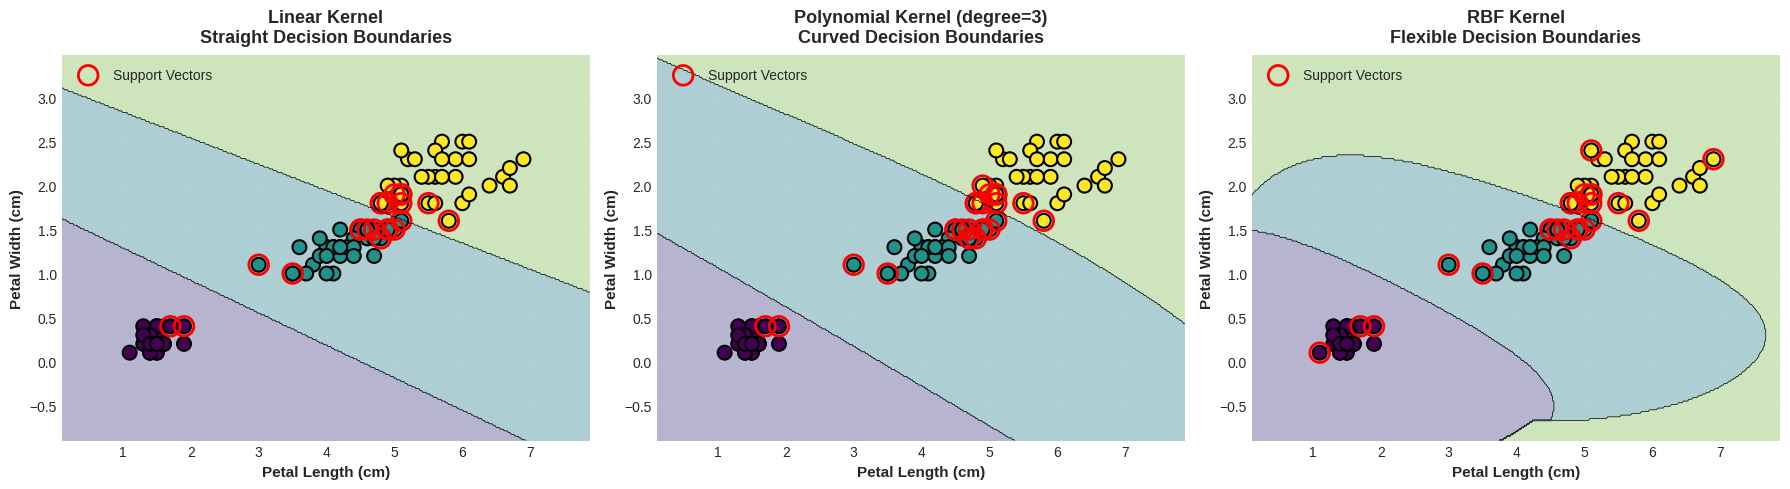


✓ Decision boundaries visualized successfully!

KEY OBSERVATIONS:
- Linear: Creates straight line boundaries
- Polynomial: Creates smoothly curved boundaries
- RBF: Creates most flexible, adaptive boundaries
- Red circles show support vectors - the 'critical' points


In [14]:
"""
This is where the magic happens! We'll visualize how each kernel creates
different decision boundaries for the same data.
"""

def plot_decision_boundary(X, y, model, title, ax, scaler=None):
    """
    Plots the decision boundary of an SVM model.

    Parameters:
    - X: Feature matrix (2D for visualization)
    - y: Target labels
    - model: Trained SVM model
    - title: Plot title
    - ax: Matplotlib axis object
    - scaler: StandardScaler object (if data was scaled)
    """
    # Create a mesh grid
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Prepare mesh points for prediction
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if scaler is not None:
        mesh_points = scaler.transform(mesh_points)

    # Predict class for each point in mesh
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(3+1)-0.5, cmap='viridis')
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, levels=np.arange(3+1)-0.5)

    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                        edgecolors='black', s=100, linewidths=1.5)

    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        support_vectors = model.support_vectors_
        if scaler is not None:
            support_vectors = scaler.inverse_transform(support_vectors)
        ax.scatter(support_vectors[:, 0], support_vectors[:, 1],
                  s=200, linewidths=2, facecolors='none',
                  edgecolors='red', label='Support Vectors')

    ax.set_xlabel(feature_names[0], fontsize=11, fontweight='bold')
    ax.set_ylabel(feature_names[1], fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

print("\n" + "="*70)
print("CREATING DECISION BOUNDARY VISUALIZATIONS")
print("="*70)

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Linear kernel
plot_decision_boundary(X_train, y_train, svm_linear,
                      'Linear Kernel\nStraight Decision Boundaries',
                      axes[0], scaler)

# Plot Polynomial kernel
plot_decision_boundary(X_train, y_train, svm_poly,
                      'Polynomial Kernel (degree=3)\nCurved Decision Boundaries',
                      axes[1], scaler)

# Plot RBF kernel
plot_decision_boundary(X_train, y_train, svm_rbf,
                      'RBF Kernel\nFlexible Decision Boundaries',
                      axes[2], scaler)

plt.tight_layout()
plt.savefig('svm_kernel_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Decision boundaries visualized successfully!")
print("\nKEY OBSERVATIONS:")
print("- Linear: Creates straight line boundaries")
print("- Polynomial: Creates smoothly curved boundaries")
print("- RBF: Creates most flexible, adaptive boundaries")
print("- Red circles show support vectors - the 'critical' points")

# DETAILED PERFORMANCE COMPARISON

In [16]:
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# Create results DataFrame
results = pd.DataFrame({
    'Kernel': ['Linear', 'Polynomial', 'RBF'],
    'Training Accuracy': [
        svm_linear.score(X_train_scaled, y_train),
        svm_poly.score(X_train_scaled, y_train),
        svm_rbf.score(X_train_scaled, y_train)
    ],
    'Testing Accuracy': [accuracy_linear, accuracy_poly, accuracy_rbf],
    'Support Vectors': [
        len(svm_linear.support_),
        len(svm_poly.support_),
        len(svm_rbf.support_)
    ]
})

print("\n" + results.to_string(index=False))


PERFORMANCE COMPARISON

    Kernel  Training Accuracy  Testing Accuracy  Support Vectors
    Linear           0.980952          0.911111               22
Polynomial           0.980952          0.911111               24
       RBF           0.980952          0.911111               25


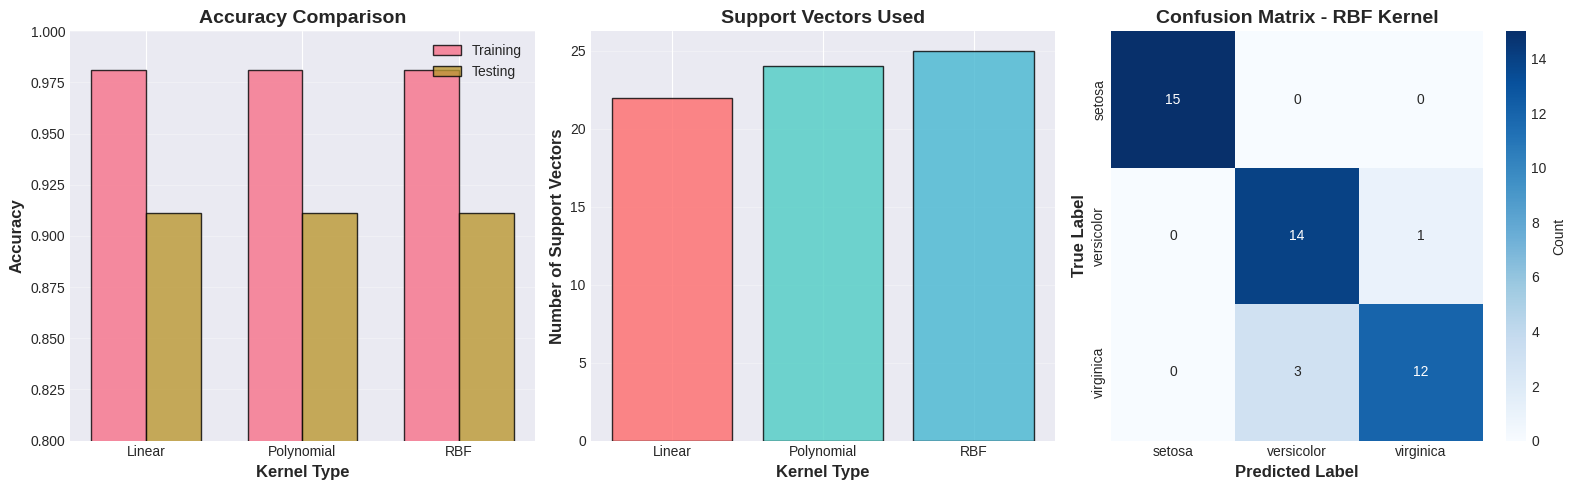


DETAILED CLASSIFICATION REPORTS

Linear Kernel Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


Polynomial Kernel Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91     

In [17]:
# Visualization of performance metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Accuracy comparison
ax1 = axes[0]
x_pos = np.arange(len(results))
width = 0.35
ax1.bar(x_pos - width/2, results['Training Accuracy'], width,
        label='Training', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, results['Testing Accuracy'], width,
        label='Testing', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Kernel Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results['Kernel'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.8, 1.0])

# Support vectors comparison
ax2 = axes[1]
colors_sv = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax2.bar(results['Kernel'], results['Support Vectors'],
        color=colors_sv, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Kernel Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Support Vectors', fontsize=12, fontweight='bold')
ax2.set_title('Support Vectors Used', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Confusion Matrix for best model (RBF in this case)
ax3 = axes[2]
cm = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=iris.target_names, yticklabels=iris.target_names,
            cbar_kws={'label': 'Count'})
ax3.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax3.set_title('Confusion Matrix - RBF Kernel', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('svm_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed classification reports
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

for kernel_name, y_pred in [('Linear', y_pred_linear),
                             ('Polynomial', y_pred_poly),
                             ('RBF', y_pred_rbf)]:
    print(f"\n{kernel_name} Kernel Classification Report:")
    print("-" * 70)
    print(classification_report(y_test, y_pred, target_names=iris.target_names))

# EFFECT OF HYPERPARAMETERS - C PARAMETER


EXPLORING THE C PARAMETER (REGULARIZATION)
C=   0.1 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 82
C=   1.0 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 25
C=  10.0 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 14
C= 100.0 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 12


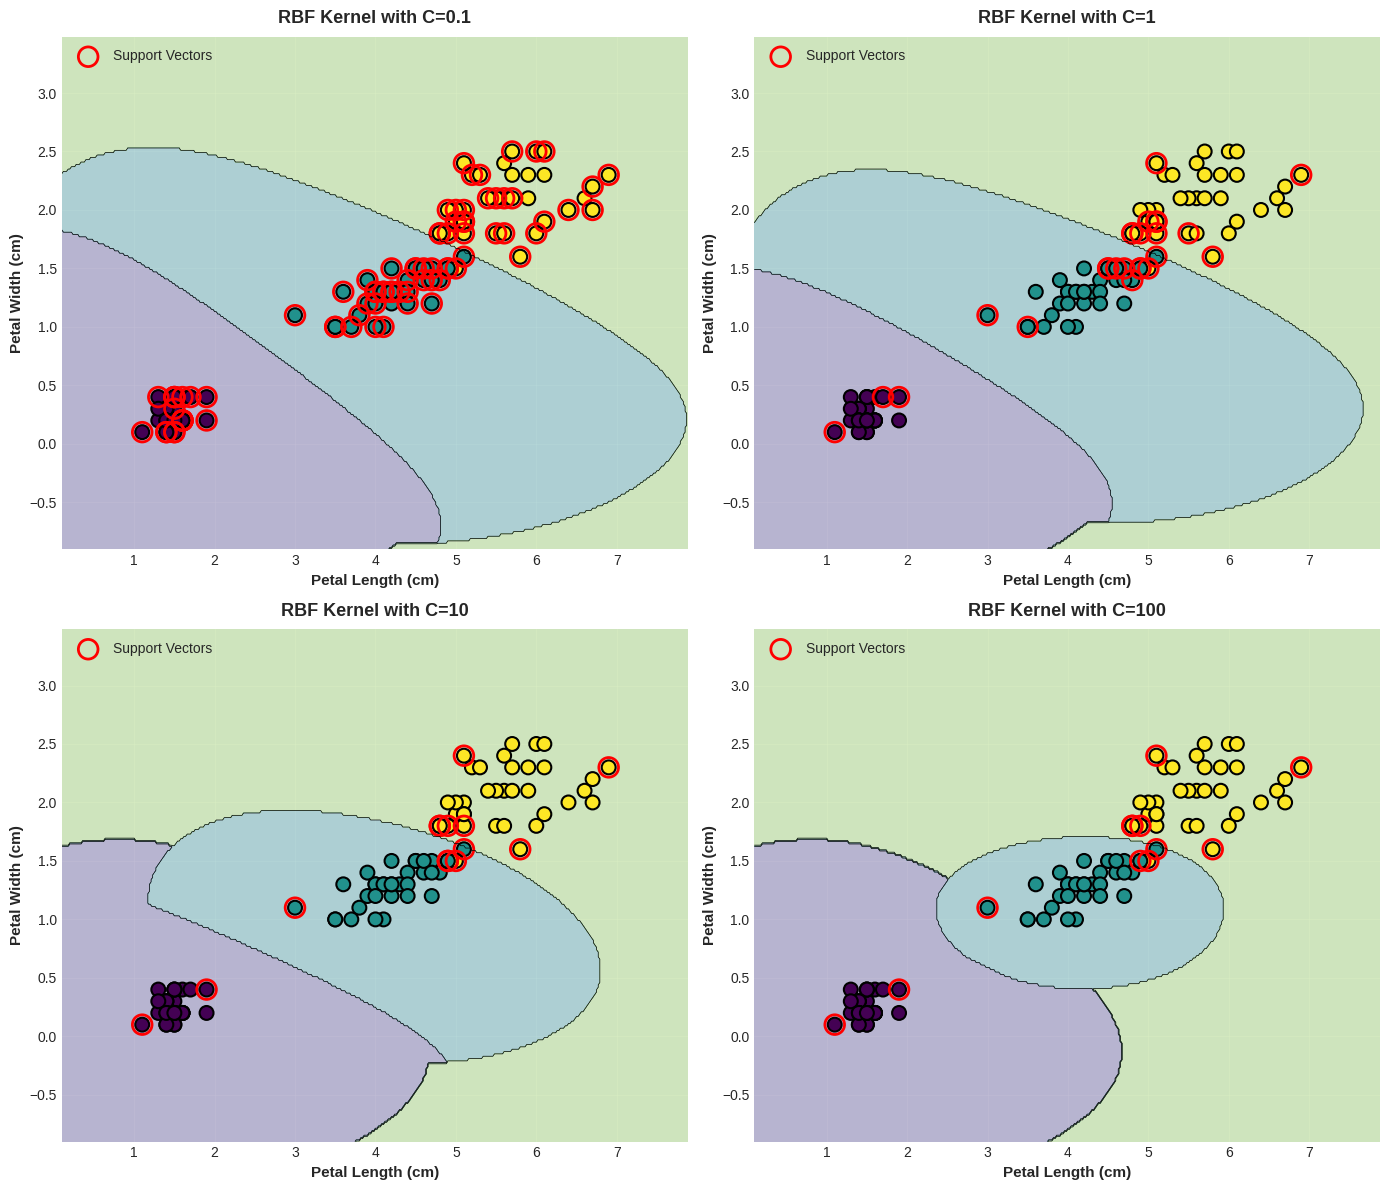


✓ C parameter exploration completed!


In [18]:
"""
THE C PARAMETER: Regularization strength

C controls the trade-off between:
- Maximizing margin (keeping boundary simple)
- Minimizing classification errors (fitting training data perfectly)

Small C (e.g., 0.1): Wider margin, more errors allowed → simpler model
Large C (e.g., 100): Narrower margin, fewer errors → complex model

Think of C as:
- Small C = "I'm okay with some mistakes for a simpler boundary"
- Large C = "I want to classify training data perfectly, even if complex"
"""

print("\n" + "="*70)
print("EXPLORING THE C PARAMETER (REGULARIZATION)")
print("="*70)

# Test different C values
C_values = [0.1, 1, 10, 100]
C_results = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train)
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    n_sv = len(model.support_)
    C_results.append([C, train_acc, test_acc, n_sv])
    print(f"C={C:6.1f} → Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, SVs: {n_sv}")

# Visualize C parameter effect
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, C in enumerate(C_values):
    model = SVC(kernel='rbf', C=C, gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train)
    plot_decision_boundary(X_train, y_train, model,
                          f'RBF Kernel with C={C}',
                          axes[idx//2, idx%2], scaler)

plt.tight_layout()
plt.savefig('svm_C_parameter_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ C parameter exploration completed!")

# EFFECT OF GAMMA PARAMETER (RBF KERNEL)


EXPLORING THE GAMMA PARAMETER (RBF KERNEL)
Gamma=   0.1 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 44
Gamma=   1.0 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 21
Gamma=  10.0 → Train Acc: 0.9810, Test Acc: 0.9556, SVs: 37
Gamma= 100.0 → Train Acc: 0.9810, Test Acc: 0.9111, SVs: 74


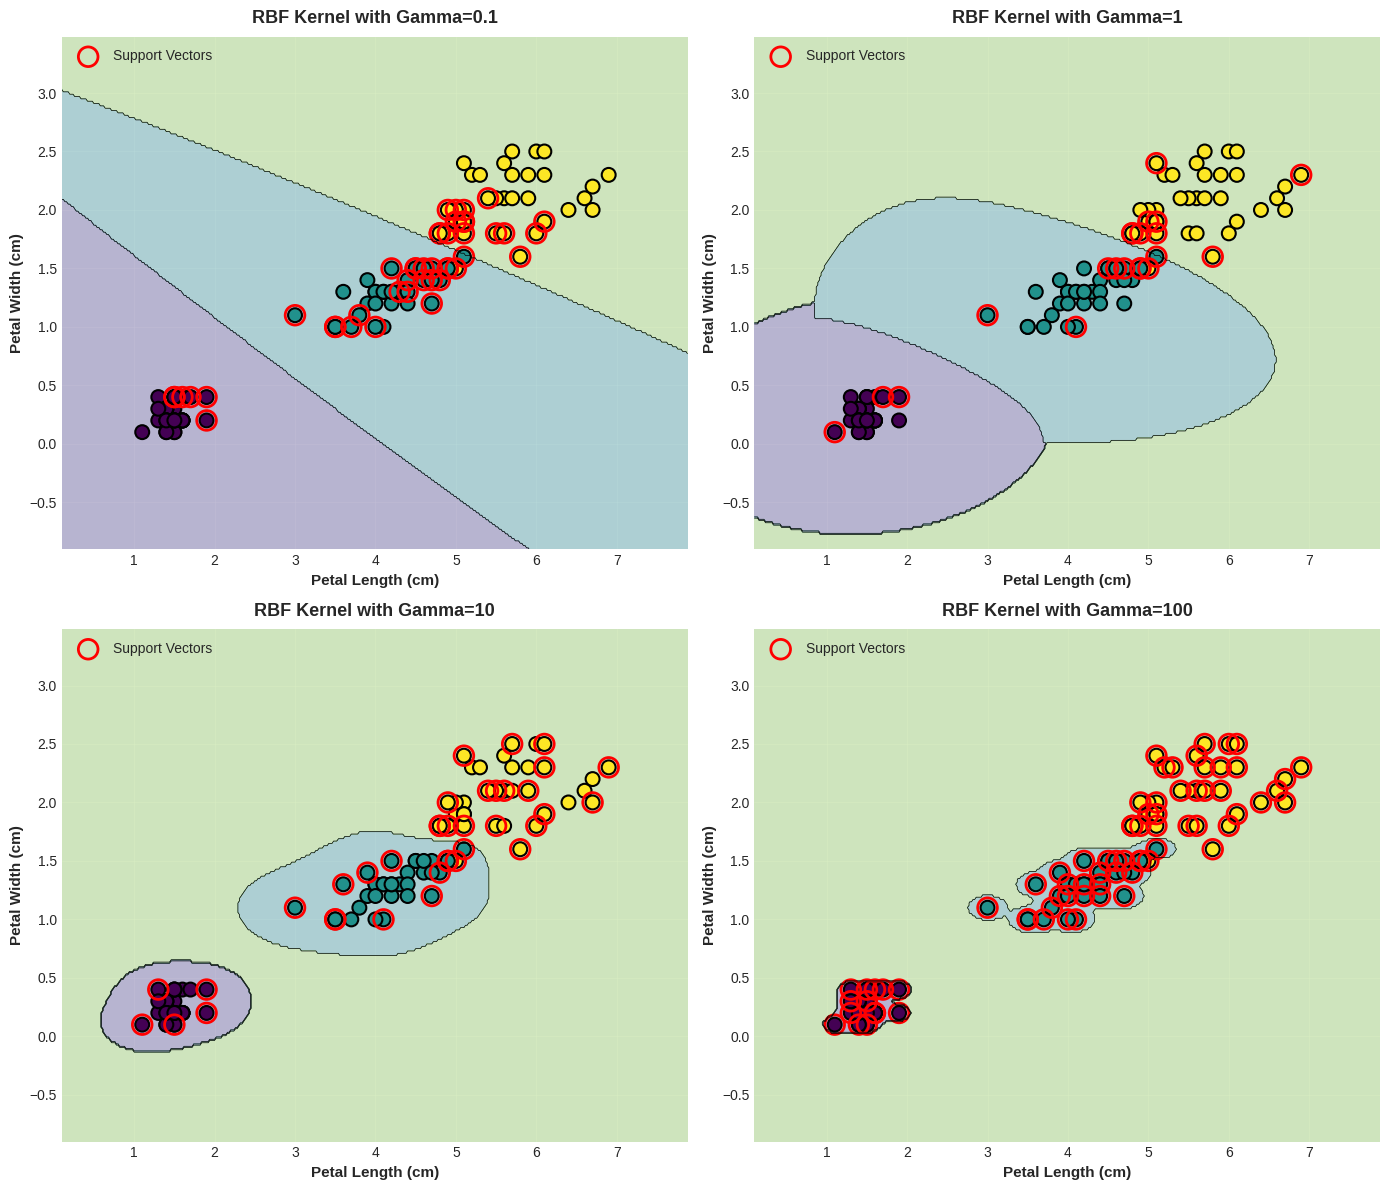


Gamma parameter exploration completed!

KEY INSIGHT:
Notice how high gamma creates 'islands' around each training point,
while low gamma creates smoother, more generalized boundaries.


In [27]:
"""
THE GAMMA PARAMETER: Kernel coefficient for RBF

Gamma defines how far the influence of a single training example reaches:

Small gamma (e.g., 0.1):
- Far reach → smooth, simple decision boundary
- Each training point affects distant regions
- Less overfitting risk

Large gamma (e.g., 10):
- Near reach → complex, wiggly decision boundary
- Each training point only affects nearby regions
- Higher overfitting risk

Think of gamma as the "radius of influence" of each training point.
"""

print("\n" + "="*70)
print("EXPLORING THE GAMMA PARAMETER (RBF KERNEL)")
print("="*70)

# Test different gamma values
gamma_values = [0.1, 1, 10, 100]
gamma_results = []

for gamma in gamma_values:
    model = SVC(kernel='rbf', C=1, gamma=gamma, random_state=42)
    model.fit(X_train_scaled, y_train)
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    n_sv = len(model.support_)
    gamma_results.append([gamma, train_acc, test_acc, n_sv])
    print(f"Gamma={gamma:6.1f} → Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, SVs: {n_sv}")

# Visualize gamma parameter effect
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, gamma in enumerate(gamma_values):
    model = SVC(kernel='rbf', C=1, gamma=gamma, random_state=42)
    model.fit(X_train_scaled, y_train)
    plot_decision_boundary(X_train, y_train, model,
                          f'RBF Kernel with Gamma={gamma}',
                          axes[idx//2, idx%2], scaler)

plt.tight_layout()
plt.savefig('svm_gamma_parameter_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGamma parameter exploration completed!")
print("\nKEY INSIGHT:")
print("Notice how high gamma creates 'islands' around each training point,")
print("while low gamma creates smoother, more generalized boundaries.")

# HYPERPARAMETER TUNING WITH GRID SEARCH

In [26]:
"""
Finding the best hyperparameters manually is tedious. Grid Search
automatically tests many combinations and finds the best one using
cross-validation.
"""

print("\n" + "="*70)
print("AUTOMATIC HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*70)

# Define parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear']
}

print(f"Testing {len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel'])} combinations...")
print("This may take a moment...\n")

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5,
                          scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train_scaled, y_train)

print("✓ Grid Search completed!\n")
print("Best parameters found:")
print(f"  Kernel: {grid_search.best_params_['kernel']}")
print(f"  C: {grid_search.best_params_['C']}")
print(f"  Gamma: {grid_search.best_params_['gamma']}")
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")
print(f"Test set score: {grid_search.score(X_test_scaled, y_test):.4f}")

# Visualize top parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score').head(10)

print("\nTop 10 parameter combinations:")
print(results_df[['param_kernel', 'param_C', 'param_gamma', 'mean_test_score']].to_string(index=False))


AUTOMATIC HYPERPARAMETER TUNING WITH GRID SEARCH
Testing 60 combinations...
This may take a moment...

✓ Grid Search completed!

Best parameters found:
  Kernel: rbf
  C: 0.1
  Gamma: 0.001

Best cross-validation score: 0.9810
Test set score: 0.9111

Top 10 parameter combinations:
param_kernel  param_C  param_gamma  mean_test_score
         rbf      0.1        0.001         0.980952
      linear      0.1        0.001         0.980952
         rbf      0.1        0.010         0.980952
      linear      0.1        0.010         0.980952
         rbf      0.1        0.100         0.980952
        poly      0.1        1.000         0.980952
         rbf      0.1        1.000         0.980952
      linear      0.1        0.100         0.980952
         rbf      1.0        0.001         0.980952
      linear      0.1       10.000         0.980952
